In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from tabulate import tabulate

## K-Means Clustering ##

Below is our implementation of the K-Means clustering algorithm. This will be used later in our manipulation of the dataset.

In [2]:
## Implementation of K-Means clustering algorithm ##
class kMeans:
    
    def __init__(self, k=8, max_iter=300):
        self.k = k
        self.max_iter = max_iter
    
    def train(self, data, TOL = 1e-3):
        centroids = np.random.rand(self.k, data.shape[1])
        centroids_old = centroids.copy()
        
        for iter in range(self.max_iter):
            dist = np.linalg.norm(data - centroids[0,:], axis=1).reshape(-1,1)
            for cls in range(1, self.k):
                dist = np.append(dist, np.linalg.norm(data - centroids[cls,:], axis=1).reshape(-1,1), axis=1)
            classes = np.argmin(dist, axis=1)
            
            for cls in set(classes):
                centroids[cls,:] = np.mean(data[classes == cls,:], axis=0)
            if np.linalg.norm(centroids - centroids_old) < TOL:
                break
            
            self.centroids = centroids
            
    def predict(self, data):
        dist = np.linalg.norm(data - self.centroids[0,:], axis=1).reshape(-1,1)
        for cls in range(1, self.k):
            dist = np.append(dist, np.linalg.norm(data - self.centroids[cls, :], axis=1).reshape(-1,1), axis=1)
        classes = np.argmin(dist, axis=1)
        return classes

## Importing our Dataset ##

First, we import our dataset into the notebook. In order to run this on your local machine, change the file location variable to the path of the beer_reviews file.

In [3]:
#file_location = ('~/COGS118Final/beer_reviews.csv')
file_location = ('C:/Users/derek/Desktop/118b/final/beer_reviews.csv')
#file_location = ('./beer_reviews.csv')
df = pd.read_csv(file_location)
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Reducing Beers to Key Categories ##

As there are over 100 unique styles of beer listed in this dataset, we will be reducing them to a few key categories in order to make working with the data easier. We will sort the beers into the following categories:

1. Dark ales will be moved under the general category of 'Dark Ale', represented by a 1.
2. Pale ales, IPAs, Bitters, Tripel, and Bière de Garde will be moved under the category of 'Pale Ale', represented by a 2.
3. Lagers, Pilsners, Rauchbier, Märzen, Altbier, Kölsch, Schwarzbier, and Keller Bier will be moved under the general category of 'Lager', represented by a 3.
4. Stouts and Porters will be moved under the general category of 'Stout', represented by a 4.
5. Any beers that do not fit in the above categories will be moved to the 'Other' category, represented by a 0.

In [4]:
# Other = 0
df['beer_category'] = 0
# Non-pale ale = 1
df['beer_category'] = df['beer_category'].where(~df['beer_style'].str.contains('^(?!.*Pale|IPA).*Ale', regex=True), 1)
# Pale ales/IPAs = 2
df['beer_category'] = df['beer_category'].where(~df['beer_style'].str.contains('Pale|IPA|Bitter|Tripel|Bière de Garde', regex=True), 2)
# Lagers = 3
df['beer_category'] = df['beer_category'].where(~df['beer_style'].str.contains('Lager|Pils|Rauchbier|Märzen|Altbier|Kölsch|Schwarzbier|Keller Bier|Bock', regex=True), 3)
# Stout/Porter = 4
df['beer_category'] = df['beer_category'].where(~df['beer_style'].str.contains('Stout|Porter'), 4)
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,beer_category
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,0
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,1
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,4
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,3
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,2


In [5]:
# create distribtuion of categories
head = ['Category', 'Percent of Reviews']
beer_categories = ['Dark ale', 'Pale ale', 'Lager', 'Stout', 'Other']
percentages = []
# Calculate percentages for 
for i in range(5):
    percent = '{:.2%}'.format(sum(df['beer_category'] == i)/len(df['beer_category']))
    percentages.append(percent)
percentages.append(percentages.pop(0))

print(tabulate(list(zip(beer_categories, percentages)), headers=head, tablefmt="grid"))

+------------+----------------------+
| Category   | Percent of Reviews   |
+============+======================+
| Dark ale   | 20.68%               |
+------------+----------------------+
| Pale ale   | 28.85%               |
+------------+----------------------+
| Lager      | 15.01%               |
+------------+----------------------+
| Stout      | 16.10%               |
+------------+----------------------+
| Other      | 19.36%               |
+------------+----------------------+


## Performing PCA on Review Data ##

In order to reduce the review data we have to a lower dimensionality, we will perform PCA in order to discover the most important components in relation to the beer category.

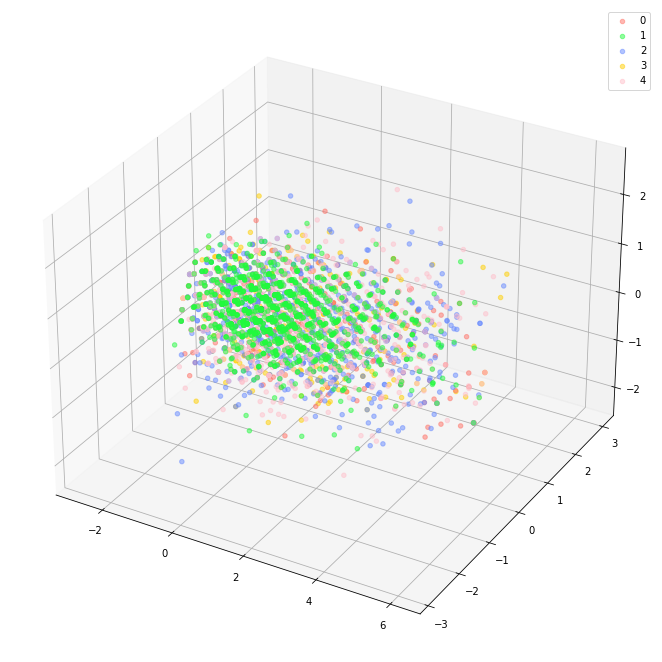

In [6]:
# Separate all review columns into 'X'
X = df[['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Separate beer category column into 'Y'
Y = df['beer_category']

# Select every 150th row for 1500000 to get 10000, avoiding bias of original set
Xa = X[:1500000].iloc[::150, :]
Ya = Y[:1500000].iloc[::150].reset_index()['beer_category']

# Use PCA to reduce to 3 principal components, and graph results
fig = plt.figure(figsize=(12,9))
ax = Axes3D(fig)
pca = decomposition.PCA(n_components=3)
pca.fit(Xa)
X1 = pca.transform(Xa)

# recombine to color code graph
graphdf = pd.DataFrame(X1).join(Ya)
colors = ['#FF7267','#22FA3E','#678AFF','#FFCF00', '#FFC0CB']

for i in range(5):
    temp = graphdf.where(Y==i).dropna()
    ax.scatter(temp[0], temp[1], temp[2], c=colors[i], label=i, alpha = .5)
ax.legend()

## Performing K-Means Clustering on PCA Data ##

Using our custom K-Means clustering algorithm above, we will now attempt to sort the resulting points into 4 clusters.

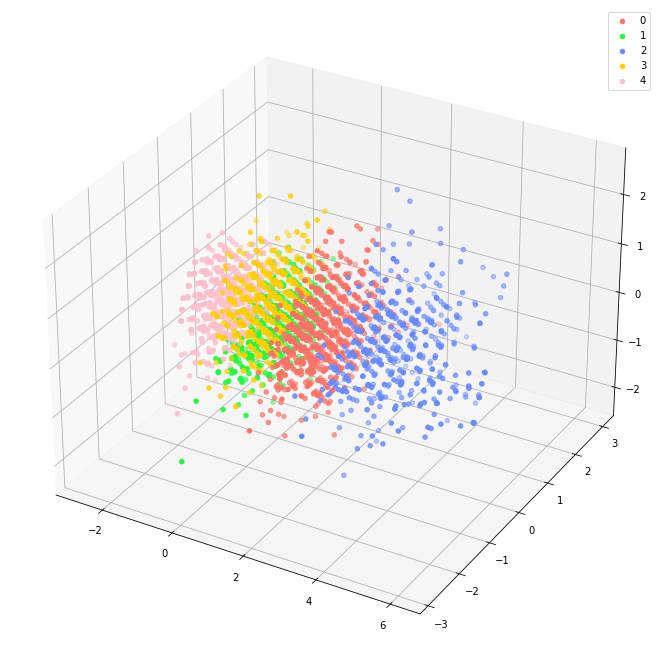

In [7]:
# new fig
fig = plt.figure(figsize=(12,9))
ax = Axes3D(fig)

# train kmeans and reclassify points
clf = kMeans(5)
clf.train(X1)
classes = clf.predict(X1)

# plot
for i in range(5):
    ax.scatter(X1[classes == i, 0], X1[classes == i, 1], X1[classes == i, 2], c=colors[i], label = i)
ax.legend()

## Evaluation of Results ##

In order to test our hypothesis, we must now compare the clusters created by k-means to the grouping we performed manually above.

In [8]:
# accuracy of k-mean cluster classification
np.mean([x == y for x,y in zip(Ya,classes)])

0.2085